# ✨ The Quiz ✨ Project Presentation


## Introduction

Hello! ✨ The Quiz ✨ project is a simple project powered by IMDb movie data. The goal is very simple: Besides getting the best possible grade 👀, the goal is to create a quiz of 10 movie-related questions. With each correct answer, players earn points according to the difficiulty level they chose. Throughout this notebook, I'll explain how I made that possible. 

Project by: Samaher Brahem

## Code Overview

### `main.py`

In the `main.py` file, the code establishes a connection to the IMDb database using the `DataManager` class to retrieve movie data. It then uses this data to create a `Quiz` class instance, setting the stage for the execution of the quiz. This file serves as the entry point, handling the database connection, data retrieval, and launching the quiz.

### `data_manager.py`

The `data_manager.py` file contains the `DataManager` class responsible for managing the IMDb database connection and data operations. 

This class handles:

- __Database Connection__: Establishes a connection to the IMDb database using provided credentials.

- __Query Execution__: Executes SQL queries and fetches data from the database.

- __Data Retrieval__: Specifically designed to retrieve movie-related data from the IMDb database, formatting it into a Pandas DataFrame for further processing.

- __Connection Closure__: Ensures proper closure of the database connection after operations are completed.

Libraries used: `Pandas` + `psycopg2`

### `quiz.py`

This file is __central__ to the quiz game, handling the game flow, question generation, and score computation. We'll see the functions included in the `Quiz` class in details in the following section.

But before we move forward, let's take a look at the structure of the data frame 'movie_data', so you can follow along in the following sections.

In [1]:
from data_manager import DataManager

# Connecting to the database
imdb_data = DataManager(
    dbname='imdb',
    user='samaher',
    password="CodingIsFun++",
    host='localhost',
    port='5432'
)

# Getting the movie data from the database
movie_data = imdb_data.get_movie()

# Printing the data frame
print(movie_data)

                 official_title country  year   votes score
0                   Family Plot     USA  1976   16864   6.8
1                  Torn Curtain     USA  1966   20400   6.7
2                        Marnie     USA  1964   36896   7.2
3     The Alfred Hitchcock Hour     USA  1962    2920   8.6
4                     The Birds     USA  1963  141405   7.7
...                         ...     ...   ...     ...   ...
1244               Gente del Po     ITA  1947     570   7.0
1245             Caccia tragica     ITA  1947     108   7.0
1246          Un pilota ritorna     ITA  1942     135   5.8
1247                     Frenzy     GBR  1972   33769   7.5
1248                     Frenzy     USA  1972   33769   7.5

[1249 rows x 5 columns]


## Main Functions

### `_determine_difficulty_level`

The logic of determining the difficulty level of the quiz is built upon 2 elements:
- __Recency__: The more recent the movie, the easier it is to recognize it. This is determined based on the release date 'year'.
- __Popularity__: The more popular the movie, the easier it is to recognize it. This is determined based on the number of votes 'votes' that are assigned to the movie on IMDb.

To make the algorithm more accurate, I added to the 'easy' category, all movies that have more than 1 MILLION votes on IMDb. Those popular movies, in my opinion, should be categorized as 'easy'.

In [ ]:
def _determine_difficulty_level(self, year, votes):
    if (year >= 2010 and votes >= 500000) or (year < 2010 and votes >= 1000000):
        return 'easy'
    elif 1990 <= year < 2010 and 100000 <= votes < 500000:
        return 'medium'
    elif year < 1990 and votes < 100000:
        return 'hard'
    else:
        return 'unknown'

### `_calculate_score`

The score is calculated this way: 

1. wrong answer: 0 points
2. correct answer:
    - 1 point if the difficulty level chosen is EASY
    - 2 points if the difficulty level chosen is MEDIUM
    - 3 points if the difficulty level chosen is HARD

In [ ]:
def _calculate_score(self, difficulty_level, is_correct):
    if is_correct:
        if difficulty_level == 'easy':
            return 1
        elif difficulty_level == 'medium':
            return 2
        elif difficulty_level == 'hard':
            return 3
    else:
        return 0

### `_find_highest_score_movie`

This method determines the movie that has the highest IMDb score. It will be used to get the correct answer for questions of this type: 'Which one of these movies has the highest score on IMDb?'

Libraries used: `NumPy` and `Pandas`

In [ ]:
def _find_highest_score_movie(self, movie_options):
    self.movie_data['score'] = pd.to_numeric(self.movie_data['score'])
    filtered_data = self.movie_data[self.movie_data['official_title'].isin(movie_options)]
    max_score_index = np.argmax(filtered_data['score'].values)
    highest_score_movie = filtered_data.iloc[max_score_index]['official_title']

    return highest_score_movie

### `_generate_question`

There are 3 types of questions included in the quiz:

1. Where was this movie produced?
2. When was this movie released? 
3. Which one of these movies has the highest score on IMDb?

`Questions of Type 1 and 2`:
The way the 2 first questions are constructed is very similar. In this case, the method begins by extracting unique attribute values from the dataset, excluding the correct answer to avoid repetition. Then, it randomly selects 3 options from the remaining values and incorporates the correct answer, shuffling the options for randomness. These options are mapped to letters (A, B, C, D) for presentation. Finally, it forms a dictionary containing the question text, the mapped options, the correct answer's corresponding letter, and the question's difficulty level, providing a ready-to-use question dictionary.

`Questions of Type 3`:
The 3rd type has a slight difference that's why it has a dedicated part in the method. For this type, it randomly selects 4 movies from the dataset, identifies the one with the highest IMDb score among them, shuffles the options, and marks the correct answer based on the highest-scored movie within the selected options.

In [ ]:
def _generate_question(self, row, desired_difficulty, question_type, correct_answer_column):
    official_title = row['official_title']
    correct_answer = row[correct_answer_column]
    year = int(row['year'])
    votes = int(row['votes'])
    difficulty_level = self._determine_difficulty_level(year, votes)

    if difficulty_level == desired_difficulty:
        if question_type == 'Which one of these movies has the highest score on IMDb?':
            all_movies = self.movie_data['official_title']
            # Randomly selecting 4 movies 
            selected_movies = random.sample(all_movies.tolist(), min(len(all_movies), 4))

            # Finding the highest-scored movie among the selected options
            highest_score_movie = self._find_highest_score_movie(selected_movies)

            other_options = selected_movies.copy()
            random.shuffle(other_options)
            options_mapping = {chr(ord('A') + i): option for i, option in enumerate(other_options)}

            # Finding the index of the correct answer within the options
            correct_answer_index = -1
            for i, option in enumerate(other_options):
                if option == highest_score_movie:
                    correct_answer_index = i
                    break

            # Ensuring correct_answer_index exists before assigning the correct_answer
            if correct_answer_index != -1:
                question_dict = {
                    'question': f'{question_type}',
                    'options': options_mapping,
                    'correct_answer': chr(ord('A') + correct_answer_index),
                    'difficulty_level': difficulty_level
                }
                return question_dict


        else:
            all_answers = list(set(self.movie_data[correct_answer_column].unique()))
            all_answers.remove(correct_answer)
            other_options = [correct_answer] + random.sample(all_answers, 3)
            random.shuffle(other_options)
            options_mapping = {chr(ord('A') + i): option for i, option in enumerate(other_options)}
            question_dict = {
                'question': f'{question_type} || {official_title} ||',
                'options': options_mapping,
                'correct_answer': chr(ord('A') + other_options.index(correct_answer)),
                'difficulty_level': difficulty_level
            }
            return question_dict

### `_display_histogram`

This method highlights how the current player performed in comparison to others who played the quiz. It visualizes everyone's scores using bars, with each player represented on the horizontal axis and their scores on the vertical axis. The bars showcase individual scores, and the current player's score is highlighted differently for easy recognition. The goal is to give a clear view of how well each player did in the game.

Library used: `Matplotlib`

In [ ]:
def _display_histogram(self, player_name):
    player_scores = {name: score for name, score in self.game_scores}
    plt.figure(figsize=(10, 6), dpi=80)

    # Extracting player names and scores
    names = list(player_scores.keys())
    scores = list(player_scores.values())

    # Getting indices to sort scores in descending order
    sorted_indices = np.argsort(scores)[::-1]

    # Rearranging names and scores based on sorted indices
    names = [names[i] for i in sorted_indices]
    scores = [scores[i] for i in sorted_indices]

    # Plotting player scores
    bars = plt.bar(names, scores, color='#202060')

    # Highlighting the current player's score in a different color and adding data label
    if player_name in player_scores:
        index = names.index(player_name)
        bars[index].set_color('#5bc8af')
        plt.text(index, scores[index], str(scores[index]), ha='center', va='bottom', fontname='Quicksand', fontsize=10)

    plt.xlabel('Players', fontname='Quicksand', fontsize=12)
    plt.ylabel('Scores', fontname='Quicksand', fontsize=12)
    plt.title('Players\' Scores Distribution', fontname='Quicksand', fontsize=16)
    plt.xticks(rotation=45, fontname='Quicksand', fontsize=10)  # Rotating x-axis labels for readability
    plt.yticks(fontname='Quicksand', fontsize=10)
    plt.grid(axis='y')  # Showing grid lines only for y-axis
    plt.tight_layout()
    plt.show()

### `_handle_scores`

This method updates the scores of the game in the JSON file and displays the histogram of the player's performance.

In [ ]:
def _handle_scores(self, player_name, total_score):
    game_score = (player_name, total_score)
    self._load_scores('game_scores.json')  # Loading existing scores

    player_exists = False
    for index, (name, score) in enumerate(self.game_scores):
        if name == player_name:
            player_exists = True
            self.game_scores[index] = (name, score + total_score)
            break

    if not player_exists:
        self.game_scores.append(game_score)

    print(f"Total score: {total_score}")
    print(f"Here's how you performed, {player_name}:")
    self._display_histogram(player_name)
    self._save_scores('game_scores.json')  # Saving scores after each game in JSON format

    return self.game_scores

### `run_quiz`

This is the core method in the `Quiz` class. It is the only public method in this class, and it is its entry point. It initiates the quiz game by prompting the player for a name and selecting a difficulty level. It generates and presents 10 questions from the different types we mentioned above. The player selects answers using multiple-choice options (A, B, C, D). The method keeps track of the player's score based on the correctness of their answers and displays the score for each question. After the game, it presents the total score, the player's performance in a histogram compared to other players, and saves the updated scores to the json file.

In [ ]:
def run_quiz(self):
    player_name = self._welcome_player()
    user_difficulty = self._choose_difficulty()

    question_generators = [
        {'generator': self._generate_question, 'params': ('When was this movie released? ==> ', 'year')},
        {'generator': self._generate_question, 'params': ('Where was this movie produced? ==> ', 'country')},
        {'generator': self._generate_question, 'params': ('Which one of these movies has the highest score on IMDb?', 'score')}
    ]

    total_score = 0
    used_questions = []

    for i in range(10):
        while True:
            question_info = None
            generator_info = random.choice(question_generators)
            question_type, correct_answer_column = generator_info['params']

            row_index = random.randint(0, len(self.movie_data) - 1)
            row = self.movie_data.iloc[row_index]

            question_info = generator_info['generator'](row, user_difficulty, question_type, correct_answer_column)

            if question_info is not None and question_info['question'] not in used_questions:
                used_questions.append(question_info['question'])
                break

        self._display_question(question_info)
        score = self._handle_answer(question_info)
        total_score += score

    self._handle_scores(player_name, total_score)

## Saving and Loading Scores

This part ensures that players' scores are stored and can be retrieved later to be used mainly in the histogram described above. The scores of each player are stored in a JSON file called `game_scores.json`.

Library used: `json`

In [ ]:
def _load_scores(self, filename):
    try:
        with open(filename, 'r') as file:
            self.game_scores = json.load(file)
    except FileNotFoundError:
        self.game_scores = []

def _save_scores(self, filename):
    with open(filename, 'w') as file:
        json.dump(self.game_scores, file)

## Demo

HELLO THERE! Welcome to ✨ The Quiz ✨
Alright, Samaher
GET READY TO PLAY 🔥
----------------------------
----------------------------
Where was this movie produced? ==>  || Se7en ||
A. AUT
B. USA
C. HUN
D. ISL
Wrong! The correct answer is: B
Your score for this question: 0
----------------------------
Where was this movie produced? ==>  || Batman v Superman: Dawn of Justice ||
A. MEX
B. USA
C. CAN
D. GTM
Correct!
Your score for this question: 1
----------------------------
Where was this movie produced? ==>  || Pulp Fiction ||
A. LIE
B. USA
C. BGR
D. DEU
Wrong! The correct answer is: B
Your score for this question: 0
----------------------------
When was this movie released? ==>  || The Social Network ||
A. 2010
B. 1956
C. 1942
D. 1928
Wrong! The correct answer is: A
Your score for this question: 0
----------------------------
When was this movie released? ==>  || Shutter Island ||
A. 2010
B. 2014
C. 1969
D. 1978
Correct!
Your score for this question: 1
----------------------------
When 

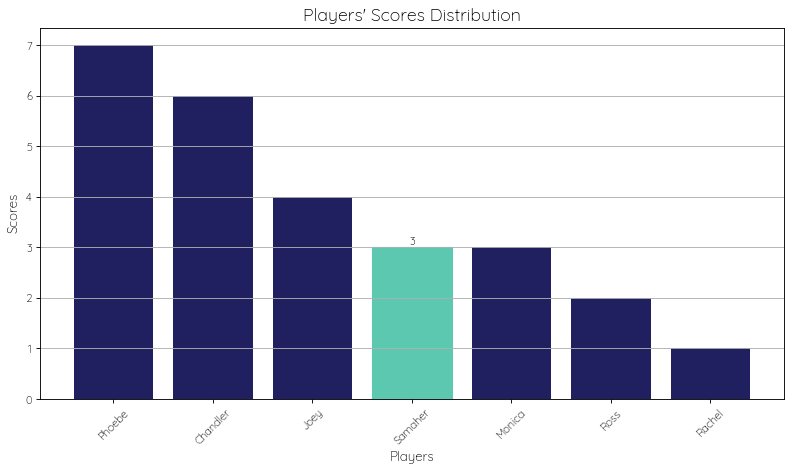

In [1]:
from data_manager import DataManager
from quiz import Quiz

try:
    # Establishing connection to the IMDb database
    imdb_data = DataManager(
        dbname='imdb',
        user='samaher',
        password="CodingIsFun++",
        host='localhost',
        port='5432'
    )

    # Getting the movie data from the database
    movie_data = imdb_data.get_movie()

    # Creating a Quiz instance with the movie data
    quiz = Quiz(movie_data)

    # Running the quiz
    quiz.run_quiz()

finally:
    # Ensuring the database connection is closed
    if 'imdb_data' in locals():
        imdb_data.close_connection()

### BONUS: `Streamlit`

Once I finished creating the quiz, I started playing around with Streamlit to build a web app. The version I've been working on is nearly operational. But here's the catch: Streamlit resets and re-executes the entire script whenever a user makes any change. Fixing this means I'll need to dig deeper into solutions like `session_state`.

You can check streamlit-related code in:
- `app.py` (which is the equivalent of main.py)
- `quiz_st.py` (which is equivalent to quiz.py)

## Final Remarks

Throughout this project, I aimed to incorporate what we've learned in class and to meet this exam modality requirements. Yet, there's always more to explore. There are a lot of ways to make this project better: Leveraging the huge database by adding other question types, giving players extra stats, and adding a timer for more excitement.